In [1]:
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os #for looping over files in a directory
import math
import json
import glob

# https://docs.google.com/document/d/1sF0uQq8MA08Dbmd2euJ9BSo1nGIrc78XAOjKQy_mimA/edit?tab=t.rq6d75o3ywqx
LoosePrimeDefs={
    "LoosePrimeRun1": 0x45fc01,
    "LoosePrime2":    0x27fc00,
    "LoosePrime3":    0x25fc00,
    "LoosePrime4":    0x05fc00,
    "LoosePrime4a":   0x21fc00,
    "LoosePrime5":    0x01fc00
}

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        elif isinstance(obj, (np.floating,)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return super().default(obj)

def load_json_file(file_path):
    """
    Loads JSON data from a file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict or list: A Python dictionary or list representing the JSON data, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{file_path}'")
        return None
    except Exception as e:
         print(f"An unexpected error occurred: {e}")
         return None

In [2]:
# some cuts, like mindphijetmet, nbjet=0, nlepton=0, already applied at preselection level for now
SRcuts={'met_met': 200,
        'mTGammaMet': 50,
        'j1_pt': 150,
        'ph_pt': 10,
        'met_signif': 25}

def getemptyresults():
    results={}
    for b in ['TT', 'TL', 'LT', 'LL']:
        results[b] = {'mc': {'nevents': 0,
                             'sumweights': 0,
                             'staterr': 0},
                      'real': {'nevents': 0,
                               'sumweights': 0,
                               'staterr': 0},
                      'jfp': {'nevents': 0,
                              'sumweights': 0,
                              'staterr': 0},
                      'efp': {'nevents': 0,
                              'sumweights': 0,
                              'staterr': 0},
                      'other': {'nevents': 0,
                                'sumweights': 0,
                                'staterr': 0},
                      'unclassified': {'nevents': 0,
                                       'sumweights': 0,
                                       'staterr': 0},
                      'data': 0
                     }
    return results

def ABCDresults(data,mask,isMC,ID="tightID",Iso="tightIso", LoosePrime="LoosePrime4"):
    masks={}

    LoosePrimeMask=LoosePrimeDefs[LoosePrime]
    
    if Iso == "noIso":
        masks['TT'] = (data[f'ph_select_{ID}']==1)
        masks['TL'] = (0==1)
        masks['LT'] = (data[f'ph_select_{ID}']==0) & ((data['ph_isEM'] & LoosePrimeMask)==0)
        masks['LL'] = (0==1)
        
    else:
        masks['TT'] = (data[f'ph_select_{ID}']==1) & (data[f'ph_select_{Iso}']==1) & ((data['ph_isEM'] & LoosePrimeMask)==0)
        masks['TL'] = (data[f'ph_select_{ID}']==1) & (data[f'ph_select_{Iso}']==0) & ((data['ph_isEM'] & LoosePrimeMask)==0)
        masks['LT'] = (data[f'ph_select_{ID}']==0) & (data[f'ph_select_{Iso}']==1) & ((data['ph_isEM'] & LoosePrimeMask)==0)
        masks['LL'] = (data[f'ph_select_{ID}']==0) & (data[f'ph_select_{Iso}']==0) & ((data['ph_isEM'] & LoosePrimeMask)==0)

    if isMC:
        real_mask  = (data['ph_truthprompt'] == 1)
        jfp_mask   = (data['ph_truthJFP']    == 1)
        efp_mask   = (data['ph_truthEFP']    == 1)
        other_mask = (data['ph_truthother']  == 1)

    if isMC:
        totalweight = data['weight_total']
        # photon weights aren't this simple, will need to adjust weights based on ABCD region. ignore for now.
        #ph_weight = data[f'ph_id_effSF_{ID}']
        #if Iso != "noIso":
        #    ph_weight *= data[f'ph_id_effSF_{Iso}']
        totalweight = data['weight_total']*data['weight_fjvt_effSF']*data['weight_ftag_effSF_GN2v01_Continuous']*data['weight_jvt_effSF']#*ph_weight
        
    results=getemptyresults()
    for b in ['TT', 'TL', 'LT', 'LL']:
        if isMC:
            results[b]['mc']['nevents']              = np.sum(            mask & masks[b])
            results[b]['mc']['sumweights']           = np.sum(totalweight[mask & masks[b]])
            results[b]['real']['nevents']            = np.sum(            mask & masks[b] & real_mask)
            results[b]['real']['sumweights']         = np.sum(totalweight[mask & masks[b] & real_mask])
            results[b]['jfp']['nevents']             = np.sum(            mask & masks[b] & jfp_mask)
            results[b]['jfp']['sumweights']          = np.sum(totalweight[mask & masks[b] & jfp_mask])
            results[b]['efp']['nevents']             = np.sum(            mask & masks[b] & efp_mask)
            results[b]['efp']['sumweights']          = np.sum(totalweight[mask & masks[b] & efp_mask])
            results[b]['other']['nevents']           = np.sum(            mask & masks[b] & other_mask)
            results[b]['other']['sumweights']        = np.sum(totalweight[mask & masks[b] & other_mask])
            results[b]['unclassified']['nevents']    = np.sum(            mask & masks[b] & ~real_mask & ~jfp_mask & ~efp_mask & ~other_mask)
            results[b]['unclassified']['sumweights'] = np.sum(totalweight[mask & masks[b] & ~real_mask & ~jfp_mask & ~efp_mask & ~other_mask])

            for t in ["mc","real","jfp","efp","other","unclassified"]:
                if results[b][t]['nevents']>0:
                    results[b][t]['staterr'] = np.sqrt((results[b][t]['sumweights']**2)/results[b][t]['nevents'])
            #print("----------------------")
            #print(totalweight[mask & masks[b] & real_mask])
            #print(len(totalweight[mask & masks[b] & real_mask]))
            #print("----------------------")
        else:
            results[b]['data'] = np.sum(mask & masks[b])
    #print("================================================")
    if results[b]['mc']['nevents'] != (results[b]['real']['nevents']+
                                       results[b]['jfp']['nevents']+
                                       results[b]['efp']['nevents']+
                                       results[b]['other']['nevents']+
                                       results[b]['unclassified']['nevents']):
        print("sums don't match")
    return results

def dumpjson(data,isMC,ID="tightID",Iso="tightIso", LoosePrime="LoosePrime4"):

    PS={}
    PS['0L'] = \
    (data['met_met']         >  SRcuts['met_met']*1000.   ) & \
    (data['jet_cleanTightBad_prod'] == 1                  ) & \
    (data['j1_pt']           >  SRcuts['j1_pt']*1000.     ) & \
    (data['ph_pt']           >  SRcuts['ph_pt']*1000.     ) & \
    (data['mindPhiJetMet']   >  0.4                       ) & \
    (data['nBTagJets']       == 0                         ) & \
    (data['nElectrons']      == 0                         ) & \
    (data['nMuons']          == 0                         ) #& \
    #(data['nTau20_baseline']        == 0                  )

    
    SR={}
    SR['0L-mT-low'] = PS['0L'] & \
    (data['mTGammaMet']      <  50.*1000.) & \
    (data['met_signif']      >  25       ) & \
    (data['mindPhiGammaJet'] >  1.5      )& \
    (data['nTau20_baseline']        == 0                  )

    SR['0L-mT-mid'] = PS['0L'] & \
    (data['mTGammaMet']      >   50*1000.) & \
    (data['mTGammaMet']      <  115*1000.) & \
    (data['met_signif']      >  20       ) & \
    (data['mindPhiGammaJet'] >  1.5      ) & \
    (data['dPhiGammaJ1']     >  1.5       )& \
    (data['nTau20_baseline']        == 0                  )

    SR['0L-mT-hgh'] = PS['0L'] & \
    (data['mTGammaMet']      >  115*1000.) & \
    (data['met_signif']      >  15       ) & \
    (data['mindPhiGammaJet'] >  1.5      ) & \
    (data['dPhiGammaJ1']     >  1.5      )& \
    (data['nTau20_baseline']        == 0                  )

    VR={}
    VR['0L-mT-mid'] = PS['0L'] & \
    (data['mTGammaMet']      >   50*1000.) & \
    (data['mTGammaMet']      <  100*1000.) & \
    (data['dPhiGammaMet']    >  2.0      )& \
    (data['nTau20_baseline']        == 0                  )
    #(data['dPhiGammaMet']    >  1.5      )
    #(data['mindPhiGammaJet'] <  1.0      )
    
    
    return {'Preselection': {'0L': ABCDresults(data, PS['0L'], isMC, ID=ID, Iso=Iso, LoosePrime=LoosePrime),
                            },
            'SR': {'0L-mT-low': ABCDresults(data, SR['0L-mT-low'], isMC, ID=ID, Iso=Iso, LoosePrime=LoosePrime),
                   '0L-mT-mid': ABCDresults(data, SR['0L-mT-mid'], isMC, ID=ID, Iso=Iso, LoosePrime=LoosePrime),
                   '0L-mT-hgh': ABCDresults(data, SR['0L-mT-hgh'], isMC, ID=ID, Iso=Iso, LoosePrime=LoosePrime),
                  },
            'VR': {'0L-mT-mid': ABCDresults(data, VR['0L-mT-mid'], isMC, ID=ID, Iso=Iso, LoosePrime=LoosePrime),
                  },
           }

In [3]:
def getfakeestimate(regiontype="SR",regionname="0L-mT-low",ID="tightID",Iso="tightIso", LoosePrime="LoosePrime4",
                    Run2=True,debug=False,tag="3.X"):
    
    totalresults=getemptyresults()
    sample_max={}
    sample_max['TL']=[0,'']
    sample_max['LT']=[0,'']
    sample_max['TT']=[0,'']
    sample_max['LL']=[0,'']
    
    samples=[]

    searchpath=f"ABCD_results_{tag}/*{ID}_{Iso}_{LoosePrime}.json"
    
    for fp in glob.glob(searchpath):
        if "gammajet" in fp: continue
        if "jetjet" in fp: continue
        if "jj" in fp: continue
        if "N2" in fp: continue

        isRun3 = ("mc23" in fp or "data_202" in fp)
        isRun2 = ("mc20" in fp or "data_201" in fp)
        
        if Run2 and not isRun2: continue # only run on one run at a time
        elif not Run2 and isRun2: continue
            
        data = load_json_file(fp)
    
        sample_tag = fp.replace(f"ABCD_results_{tag}/output_","").replace(".json","")
        samples.append(sample_tag)

        region=data[regiontype][regionname]
        
        for b in ['TT', 'TL', 'LT', 'LL']:
            totalresults[b]['data'] += region[b]["data"]

            for t in ['real','jfp','efp','other','unclassified']:
                for s in ["sumweights","nevents"]:
                    totalresults[b][t][s] += region[b][t][s]
                if "staterr" in totalresults[b][t] and "staterr" in region[b][t]:
                    # keep track of the stat error squared, we'll take square root later.
                    #totalresults[b][t]["staterr"] += region[b][t]['sumweights']**2./region[b][t]["nevents"]
                    totalresults[b][t]["staterr"] += region[b][t]["staterr"]**2.
            
        
            if sample_max[b][0] < region[b]["real"]["sumweights"]:
                sample_max[b][0] = region[b]["real"]["sumweights"]
                sample_max[b][1] = sample_tag
                
    for b in ['TT', 'TL', 'LT', 'LL']:
        for t in ['real','jfp','efp','other','unclassified']:
            if "staterr" in totalresults[b][t]:
                totalresults[b][t]["staterr"] = np.sqrt(totalresults[b][t]["staterr"])
        
    if debug:
        print(json.dumps(totalresults,indent=4,cls=NumpyEncoder))

        print("Most contributing samples:")
        for b in ['TT', 'TL', 'LT', 'LL']:
            print(f"{b}: {sample_max[b][1][:-1]}")
        
        mcs_data=load_json_file(f"ABCD_results/output_{sample_max['TT'][1]}.json")
        print(json.dumps(mcs_data,indent=4,cls=NumpyEncoder))

    return totalresults,samples

def getsignalestimate(regiontype="SR",regionname="0L-mT-low",ID="tightID",Iso="tightIso",LoosePrime="LoosePrime4",sample="N2_200_N1_190",Run2=True,debug=False,tag="3.X"):
    signalresults=getemptyresults()
    
    for fp in glob.glob(f"ABCD_results_{tag}/*{sample}*{ID}_{Iso}_{LoosePrime}.json"):
        data = load_json_file(fp)
    
        isRun3 = ("mc23" in fp or "data_202" in fp)
        isRun2 = ("mc20" in fp or "data_201" in fp)
        
        if Run2 and not isRun2: continue # only run on one run at a time
        elif not Run2 and isRun2: continue

        region=data[regiontype][regionname]
        
        for b in ['TT', 'TL', 'LT', 'LL']:
            # need to sum nevents also, and keep track of uncertainties.  less an issue for signal.
            signalresults[b]['data'] += region[b]["data"]
            signalresults[b]['real']['sumweights'] += region[b]["real"]["sumweights"]
            signalresults[b]['jfp']['sumweights'] += region[b]["jfp"]["sumweights"]
            signalresults[b]['efp']['sumweights'] += region[b]["efp"]["sumweights"]
            signalresults[b]['other']['sumweights'] += region[b]["other"]["sumweights"]
            signalresults[b]['unclassified']['sumweights'] += region[b]["unclassified"]["sumweights"]

    return signalresults

In [4]:
tag="3.Y"
base_path = f"/data/mhance/SUSY/ntuples/v{tag}"

In [5]:
try:
    os.mkdir(f"ABCD_results_{tag}")
except:
    pass

# Iterate over subdirectories and files
for root, _, files in os.walk(base_path):
    for file in files:
        if not file.endswith('.root'): continue
        if "a.root" in file or "d.root" in file or "e.root" in file: continue
        #if "N2_" in file: continue

        #if not "data_20" in file: continue
        filepath = os.path.join(root, file)
        if "output_" not in filepath: continue

        #if "data_" not in filepath: continue
        #if filepath != "/data/mhance/SUSY/ntuples/v3/output_Wtaunugamma.root": continue
        #if filepath != "/data/mhance/SUSY/ntuples/v3/output_data_2018.root": continue
        #if filepath != "/data/mhance/SUSY/ntuples/v3/output_Znunu_CVetoBVeto.root": continue
        #if filepath != "/data/mhance/SUSY/ntuples/v3/output_N2_220_N1_200_HH.root": continue
        #if filepath != "/data/mhance/SUSY/ntuples/v3.1/output_Wenu_CVetoBVeto_mc20a.root": continue
        #print(filepath)

        # comment this line to produce new JSON files
        continue
        with uproot.open(filepath) as f:
            #print(filepath)
            if 'picontuple' in f:
                tree = f['picontuple']
                # Extract the data
                data = tree.arrays(library="np")
                #data['met_signif'] = data['met_met']/data['ph_pt']

                for ID in ["mediumID", "tightID"]:
                    for Iso in ["looseIso", "tightIso", "tightCOIso", "hybridIso", "noIso","hybridCOIso"]:
                        for LoosePrime in ["LoosePrime2","LoosePrime3","LoosePrime4"]: #,"LoosePrime4a","LoosePrime5"]:
                            results=dumpjson(data,"data_" not in filepath, ID, Iso, LoosePrime)
                            #print(json.dumps(results, indent=4, cls=NumpyEncoder))
                            with open(f"ABCD_results_{tag}/"+file.replace(".root",f"_ABCD_{ID}_{Iso}_{LoosePrime}.json"),'w') as jf:
                                json.dump(results, jf, indent=4, cls=NumpyEncoder)

In [6]:
sigsamples=["N2_200_N1_185_WB",
            "N2_200_N1_190_WB",
            "N2_200_N1_195_WB",
            "N2_200_N1_197_WB"]


def yieldsABCD(sresults,useMC=True):
    mininden=.1
    
    N_all={}
    for b in ['TT', 'TL', 'LT', 'LL']:
        if useMC:
            N_all[b] = sresults[b]['real']['sumweights']+sresults[b]['jfp']['sumweights']+sresults[b]['efp']['sumweights']+sresults[b]['other']['sumweights']
        else:
            N_all[b] = sresults[b]['data']
        
    # prompt subtraction
    num_TL = (N_all['TL']-sresults['TL']['real']['sumweights']-sresults['TL']['efp']['sumweights'])
    num_LT = (N_all['LT']-sresults['LT']['real']['sumweights']-sresults['LT']['efp']['sumweights'])
    den_LL = (N_all['LL']-sresults['LL']['real']['sumweights']-sresults['LL']['efp']['sumweights'])
    
    # calculate uncertainty
    d_TL = np.sqrt( abs(N_all['TL']) + (sresults['TL']['real']['staterr']**2) + (sresults['TL']['efp']['staterr']**2))
    d_LT = np.sqrt( abs(N_all['LT']) + (sresults['LT']['real']['staterr']**2) + (sresults['LT']['efp']['staterr']**2))
    d_LL = np.sqrt( abs(N_all['LL']) + (sresults['LL']['real']['staterr']**2) + (sresults['LL']['efp']['staterr']**2))

    # ABCD yield
    N_TT_jfp_est = 0.
    if den_LL > 0:
        N_TT_jfp_est = num_TL*num_LT/den_LL

    # ABCD uncertainty
    d_TT_jfp_est = 0.1
    if den_LL > 0 and N_TT_jfp_est>0:
        d_TT_jfp_est = abs(N_TT_jfp_est * np.sqrt((d_TL/max(mininden,num_TL))**2 + (d_LT/max(mininden,num_LT))**2 + (d_LL/max(mininden,den_LL))**2))

    return N_TT_jfp_est,d_TT_jfp_est,den_LL
   

def printregion(regiontype="SR", region="0L-mT-low", Run2=True, LoosePrime="LoosePrime4", debugoutput = False):
    blindTT = (regiontype == "SR")    

    IDs=["tightID"]
    Isos=["hybridCOIso"]
    if not debugoutput:
        print(f"{regiontype}-{region}")
        print("------------")
        print(f"      ID    Isolation :   JFP,MC   JFP,DD              {sigsamples[0]}   {sigsamples[1]}   {sigsamples[2]}   {sigsamples[3]}")
        print("----------------------------------------------------------------------------------------------------------")
        #IDs=["mediumID","tightID"]
        #Isos=["looseIso", "tightIso", "tightCOIso", "hybridIso", "hybridCOIso", "noIso"]

        
    for ID in IDs:
        for Iso in Isos:
            if debugoutput: print(f"Results for {ID}, {Iso}:\n")
            
            totalresults,samples=getfakeestimate(regiontype,region,ID,Iso,LoosePrime,Run2,False,tag=tag)
            
            N={}
            N_MC={}
            N_JFP_MC={}
            if debugoutput: print(f"      Data       MC      Real      EFP    Other      JFP")
            for b in ['TT', 'TL', 'LT', 'LL']:
                N[b] = totalresults[b]['data']-totalresults[b]['real']['sumweights']-totalresults[b]['efp']['sumweights']
                N_JFP_MC[b] = totalresults[b]['jfp']['sumweights'] + totalresults[b]['other']['sumweights'] 
                N_MC[b] = N_JFP_MC[b] + totalresults[b]['real']['sumweights'] + totalresults[b]['efp']['sumweights']
                if debugoutput:
                    print(f"{b}: {totalresults[b]['data'] if b != 'TT' or (not blindTT) else 0:6d}   {N_MC[b]:6.1f}    {totalresults[b]['real']['sumweights']:6.1f}   {totalresults[b]['efp']['sumweights']:6.1f}   {totalresults[b]['other']['sumweights']:6.1f}   {totalresults[b]['jfp']['sumweights']:6.1f}")
            if debugoutput: print('')

            
            N_TT_bkg_DDjfp,U_TT_bkg_DDjfp,den_LL = yieldsABCD(totalresults,False)
            
            if N_JFP_MC['LL']>0:
                N_TT_bkg_DDMCjfp = N_JFP_MC['TL']*N_JFP_MC['LT']/N_JFP_MC['LL']
            else:
                N_TT_bkg_DDMCjfp = 0
            
            N_TT_bkg_real = totalresults['TT']['real']['sumweights']
            N_TT_bkg_other = totalresults['TT']['other']['sumweights']
            N_TT_bkg_MCjfp = totalresults['TT']['jfp']['sumweights']
            N_TT_bkg_efp = totalresults['TT']['efp']['sumweights']
            N_TT_bkg_unclassified = totalresults['TT']['unclassified']['sumweights']
            
            N_TT_bkg_MC = N_TT_bkg_MCjfp + N_TT_bkg_real + N_TT_bkg_other + N_TT_bkg_efp
            
            N_TT_bkg_DD = N_TT_bkg_DDjfp + N_TT_bkg_real + N_TT_bkg_efp
            
            N_TT_bkg_DDMC = N_TT_bkg_DDMCjfp + N_TT_bkg_real + N_TT_bkg_efp
            
            if debugoutput: print(f"N_TT_bkg = ({N['TL']:.1f}*{N['LT']:.1f})/({N['LL']:.1f}) = {N_TT_bkg_DDjfp:.1f}")
            
            if debugoutput: print("")
    
            if debugoutput:
                if not blindTT:
                    print(f"Total data in TT region is {totalresults['TT']['data']:.1f}.")
                print(f"DD background prediction: {N_TT_bkg_real:5.1f} (real) + {N_TT_bkg_DDjfp:5.1f} (+/- {U_TT_bkg_DDjfp:.2f}) (jfp+other) + {N_TT_bkg_efp:.1f} (efp) + {N_TT_bkg_unclassified:.1f} (unclassified) = {N_TT_bkg_DD:.1f}")
                print(f"MC background prediction: {N_TT_bkg_real:5.1f} (real) + {N_TT_bkg_MCjfp+N_TT_bkg_other:5.1f}             (jfp+other) + {N_TT_bkg_efp:.1f} (efp) + {N_TT_bkg_unclassified:.1f} (unclassified) = {N_TT_bkg_MC:.1f}")    
                print(f"MC background closure   : {N_TT_bkg_real:5.1f} (real) + {N_TT_bkg_DDMCjfp:5.1f}             (jfp+other) + {N_TT_bkg_efp:.1f} (efp) + {N_TT_bkg_unclassified:.1f} (unclassified) = {N_TT_bkg_DDMC:.1f}")        
                print(f"SF for DD fakes to close with data: {((totalresults['TT']['data']-N_TT_bkg_real-N_TT_bkg_efp-N_TT_bkg_unclassified)/N_TT_bkg_DDjfp):.3f}")
    
            yields={}
            yieldsstring=""
            for sigsample in sigsamples:
                sigsampleresults=getsignalestimate(regiontype,region,ID,Iso,LoosePrime,sigsample,Run2,False,tag=tag)
                #print(json.dumps(sigsampleresults,indent=4))
                yields[sigsample]=sigsampleresults['TT']['real']['sumweights']
                if debugoutput: print(f"Signal sample {sigsample} has {yields[sigsample]:.1f} events")
                yieldsstring += f"{yields[sigsample]:13.1f}   "
                
            if not debugoutput:
                print(f"{ID:10s} {Iso:11s}:   {N_TT_bkg_MCjfp+N_TT_bkg_other:6.1f}    {N_TT_bkg_DDjfp:5.1f} +/- {U_TT_bkg_DDjfp:4.1f}     {yieldsstring}")
            print("----------------------------------------------------------------------------------------------------------")
    print("")

regiontype="SR"
region="0L-mT-low"
LoosePrime="LoosePrime4" # change me to see new results

#regiontype="VR"
#region="0L-mT-mid"
#debugoutput=True

for region in ["0L-mT-low","0L-mT-mid","0L-mT-hgh"]:
    printregion(r"SR", region, True, LoosePrime)
printregion(r"VR", "0L-mT-mid", True, LoosePrime)
printregion(r"VR", "0L-mT-mid", True, LoosePrime, debugoutput=True)

SR-0L-mT-low
------------
      ID    Isolation :   JFP,MC   JFP,DD              N2_200_N1_185_WB   N2_200_N1_190_WB   N2_200_N1_195_WB   N2_200_N1_197_WB
----------------------------------------------------------------------------------------------------------
tightID    hybridCOIso:      0.9      2.0 +/-  2.5               5.5            13.1            14.1            11.7   
----------------------------------------------------------------------------------------------------------

SR-0L-mT-mid
------------
      ID    Isolation :   JFP,MC   JFP,DD              N2_200_N1_185_WB   N2_200_N1_190_WB   N2_200_N1_195_WB   N2_200_N1_197_WB
----------------------------------------------------------------------------------------------------------
tightID    hybridCOIso:     17.3      8.1 +/-  5.1              44.7            43.6            21.3             7.5   
----------------------------------------------------------------------------------------------------------

SR-0L-mT-hgh
-------

Quick function that will test closure for any single sample.

In [7]:
def sampleABCD(sample,debug=False,ID="tightID",Iso="hybridIso",LoosePrime="LoosePrime4a",regiontype="SR",region="0L-mT-mid"):
    sresults=None
    if isinstance(sample,str):
        sname=f"ABCD_results_{tag}/output_{sample}.json"
        sresults=load_json_file(sname)[regiontype][region]
        #print(json.dumps(results,indent=4,cls=NumpyEncoder))
    elif isinstance(sample,dict):
        sresults=sample
    else:
        print("Must provide either valid sample string or dictionary of results.")
        return None

    # N_all={}
    # for b in ['TT', 'TL', 'LT', 'LL']:
    #     N_all[b] = sresults[b]['real']['sumweights']+sresults[b]['jfp']['sumweights']+sresults[b]['efp']['sumweights']+sresults[b]['other']['sumweights']

    # num_TL = (N_all['TL']-sresults['TL']['real']['sumweights']-sresults['TL']['efp']['sumweights'])
    # num_LT = (N_all['LT']-sresults['LT']['real']['sumweights']-sresults['LT']['efp']['sumweights'])
    # den_LL = (N_all['LL']-sresults['LL']['real']['sumweights']-sresults['LL']['efp']['sumweights'])
    # N_TT_jfp_est = 0.
    # if den_LL > 0:
    #     N_TT_jfp_est = num_TL*num_LT/den_LL
    N_TT_jfp_est,d_TT_jfp_est,den_LL = yieldsABCD(sresults)

    shortsample=sample.replace(f"_ABCD_{ID}_{Iso}_{LoosePrime}","")
    sigma=-5.2
    ratio=-0.1
    if debug and den_LL > 0 and sresults['TT']['jfp']['sumweights']>0:
        MCJFPtotal=(sresults['TT']['jfp']['sumweights']+sresults['TT']['other']['sumweights'])
        ratio=(N_TT_jfp_est)/MCJFPtotal
        dratio=(d_TT_jfp_est)/MCJFPtotal
        sigma=(ratio-1.)/dratio
        print(f"{shortsample:60s} {sresults['TT']['real']['sumweights']:6.1f}  {sresults['TT']['efp']['sumweights']:6.1f}   {sresults['TT']['other']['sumweights']:6.1f}   {sresults['TT']['jfp']['sumweights']:6.1f}  {N_TT_jfp_est:6.1f} +/- {d_TT_jfp_est:4.1f}  {ratio:6.2f} +/- {d_TT_jfp_est/MCJFPtotal:4.2f} = {sigma:4.1f} sigma")
    elif debug:
        print(f"{shortsample:60s} {sresults['TT']['real']['sumweights']:6.1f}  {sresults['TT']['efp']['sumweights']:6.1f}   {sresults['TT']['other']['sumweights']:6.1f}   {sresults['TT']['jfp']['sumweights']:6.1f}  {N_TT_jfp_est:6.1f} +/- {d_TT_jfp_est:4.1f}  ")
        
    return N_TT_jfp_est,sigma,ratio

def printallsamples(ID="tightID",Iso="hybridIso",LoosePrime="LoosePrime4a",Run2=True,regiontype="SR",region="0L-mT-mid"):
    totalresults,samples=getfakeestimate(regiontype,region,ID,Iso,LoosePrime,Run2,debug=False)
    print(f"{"Run2" if Run2 else "Run3"} {"Sample":55s} {"Prompt":6s}     {"EFP":6s} {"Other":6s} {"MC JFPs":6s}    {"ABCD":16s}{"ABCD/MC":6s}")
    print("------------------------------------------------------------------------------------------------------------------------")
    sigmas=[]
    ratios=[]
    for s in sorted(samples):
        est,sigma,ratio=sampleABCD(s,True,ID,Iso,LoosePrime,regiontype,region)
        sigmas.append(sigma)
        ratios.append(ratio)
        
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax1.hist(sigmas, bins=50, range=(-5,5))
    ax1.set_xlabel('ABCD - Truth [$\\sigma$]')
    ax1.set_ylabel('Number of MC Samples')
    ax1.grid(True)

    ax2.hist(ratios, bins=50, range=(0,3))
    ax2.set_xlabel('ABCD/Truth')
    ax2.set_ylabel('Number of MC Samples')
    ax2.grid(True)

Run3 Sample                                                  Prompt     EFP    Other  MC JFPs    ABCD            ABCD/MC
------------------------------------------------------------------------------------------------------------------------
MGH7EG_tty_dec_mc23                                             0.0     0.0      0.0      0.0     0.0 +/-  0.1  
MGPy8EG_tty_dec_mc23                                            0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_ttbar_hdamp258p75_SingleLep_mc23                    0.1     0.1      1.2      0.8     0.7 +/-  1.4    0.36 +/- 0.68 = -0.9 sigma
PhPy8EG_A14_ttbar_hdamp258p75_allhad_mc23                       0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_ttbar_hdamp258p75_dil_mc23                          0.0     0.0      0.0      0.2     0.0 +/-  0.2    0.22 +/- 1.01 = -0.8 sigma
PhPy8EG_tW_dyn_DR_incl_antitop_mc23                             0.1     0.0      0.0      0.3     0.1 +/-  0.4    0.30 +/- 1.59 = -0.4 si

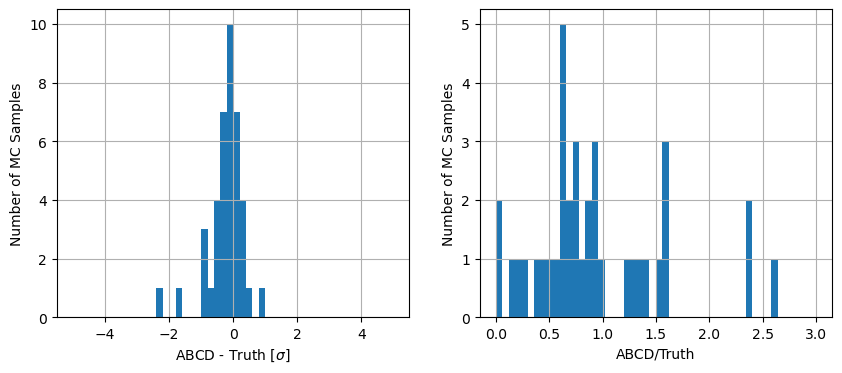

In [8]:
ID="tightID"
Iso="hybridCOIso"
LoosePrime="LoosePrime4"
Run2=False
regiontype="VR"
region="0L-mT-mid"
printallsamples(ID, Iso, LoosePrime, Run2, regiontype, region)

Run2 Sample                                                  Prompt     EFP    Other  MC JFPs    ABCD            ABCD/MC
------------------------------------------------------------------------------------------------------------------------
MGPy8EG_tty_yfromdec_mc20                                       0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_tchan_BW50_had_antitop_mc20                         0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_tchan_BW50_had_top_mc20                             0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_tchan_BW50_lept_antitop_mc20                        0.0     0.0      0.0      0.0     0.1 +/-  0.5  
PhPy8EG_A14_tchan_BW50_lept_top_mc20                            0.0     0.2      0.1      0.2     0.4 +/-  1.2    1.49 +/- 4.49 =  0.1 sigma
PhPy8EG_tW_dyn_DR_incl_antitop_mc20                             0.0     0.0      0.3      0.0     1.4 +/-  4.7  
PhPy8EG_tW_dyn_DR_incl_top_mc20                     

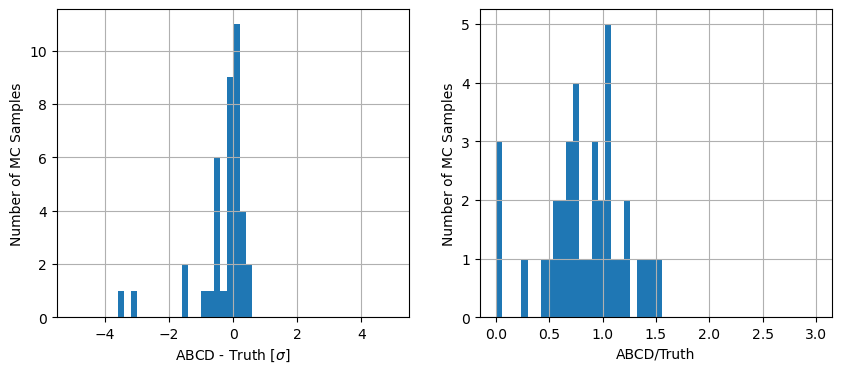

In [9]:
Run2=True
printallsamples(ID, Iso, LoosePrime, Run2, regiontype, region)

Run2 Sample                                                  Prompt     EFP    Other  MC JFPs    ABCD            ABCD/MC
------------------------------------------------------------------------------------------------------------------------
MGPy8EG_tty_yfromdec_mc20                                      30.4     0.7      0.6      0.4     0.4 +/-  2.6    0.40 +/- 2.79 = -0.2 sigma
PhPy8EG_A14_tchan_BW50_had_antitop_mc20                         0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_tchan_BW50_had_top_mc20                             0.0     0.0      0.0      0.0     0.0 +/-  0.1  
PhPy8EG_A14_tchan_BW50_lept_antitop_mc20                        3.6     5.4      2.8      3.2     3.9 +/-  3.5    0.65 +/- 0.58 = -0.6 sigma
PhPy8EG_A14_tchan_BW50_lept_top_mc20                           11.4    11.5      7.9      5.7    10.2 +/-  5.7    0.75 +/- 0.42 = -0.6 sigma
PhPy8EG_tW_dyn_DR_incl_antitop_mc20                            11.7    12.0      8.8      6.1    10.2 +/-  5.

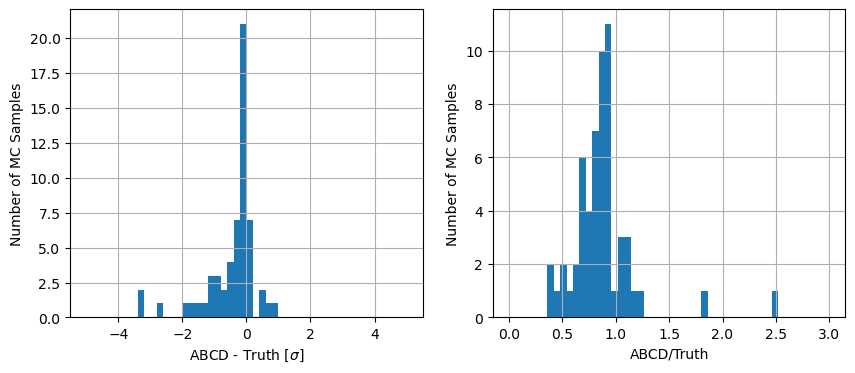

In [10]:
Run2=True
regiontype="Preselection"
region="0L"
printallsamples(ID, Iso, LoosePrime, Run2, regiontype, region)

Run3 Sample                                                  Prompt     EFP    Other  MC JFPs    ABCD            ABCD/MC
------------------------------------------------------------------------------------------------------------------------
MGH7EG_tty_dec_mc23                                             5.4     0.3      9.2      0.1     4.8 +/-  9.4    0.52 +/- 1.01 = -0.5 sigma
MGPy8EG_tty_dec_mc23                                           12.4     0.2      0.3      0.1     0.3 +/-  2.1    0.68 +/- 5.71 = -0.1 sigma
PhPy8EG_A14_ttbar_hdamp258p75_SingleLep_mc23                   60.2    48.0     44.0     35.5    46.0 +/- 10.2    0.58 +/- 0.13 = -3.3 sigma
PhPy8EG_A14_ttbar_hdamp258p75_allhad_mc23                       0.0     0.0      0.4      0.0     0.0 +/-  0.1  
PhPy8EG_A14_ttbar_hdamp258p75_dil_mc23                          9.5    10.9      5.1      5.0     5.5 +/-  3.8    0.54 +/- 0.37 = -1.2 sigma
PhPy8EG_tW_dyn_DR_incl_antitop_mc23                             5.2     5.5      

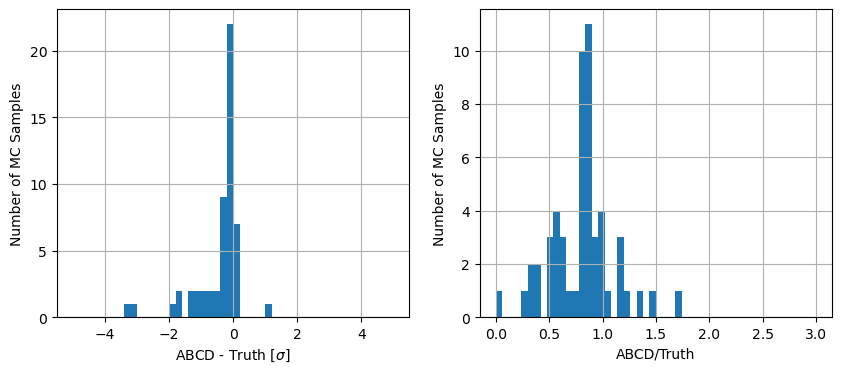

In [11]:
Run2=False
regiontype="Preselection"
region="0L"
printallsamples(ID, Iso, LoosePrime, Run2, regiontype, region)